## Imports

In [183]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json
import copy
from plotly.subplots import make_subplots
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize
from datetime import datetime
from collections import defaultdict

In [195]:
data = json.load(open('research/output/youtube_data.json'))

## Processing

In [196]:
persuasions = ["Social Identity", "Concreteness", "Anchoring and Comparison", "Overcoming Reactance", "Reciprocity",
"Foot in the Door", "Authority", "Social Impact", "Anthropomorphism", "Scarcity", "Social Proof", "Unclear"]
sector_list = {"Technology": "#19A7CE", 
               "Media": "#F24C3D", 
               "Retailing and Apparel": "#F2BE22", 
               "Finance": "#00DFA2", 
               "Food and Household": "#F97B22", 
               "Wholesalers, Industrials and Energy": "#77037B", 
               "Transportation": "#413543",
               "Aerospace and Defence": "#090580",
               "Healthcare": "#FFACAC"}
year_list = ["Before 2014", '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
seasons = ["Spring", "Summer", "Monsoon", "Autumn", "Winter"]

month_to_season = {
    "Jan": "Winter",
    "Feb": "Winter",
    "Mar": "Spring",
    "Apr": "Spring",
    "May": "Spring",
    "Jun": "Summer",
    "Jul": "Summer",
    "Aug": "Monsoon",
    "Sep": "Monsoon",
    "Oct": "Monsoon",
    "Nov": "Autumn",
    "Dec": "Winter"
}

In [197]:
frequency = {}
for video, values in data.items():
    for i, strat in enumerate(values["annots"]):
        if strat not in frequency:
            frequency[strat] = {"overall":0}
        frequency[strat]["overall"] += 1

In [209]:
companies = {}
for video, values in data.items():
    company = values["channelTitle"]
    if company not in companies:
        companies[company] = {"count":0, "videos":{}}
    y = values["publishedAt"][0:4]
    if int(y) <= 2013:
        y = "Before 2014"
    companies[company]["count"] += 1
    companies[company]["videos"][video] = {"annots":values["annots"], "publishedIn": y, "likeCount": values["likeCount"], "publishedAt":values["publishedAt"], "publishedIn": y,
                                         "viewCount":values["viewCount"], "sector": values["sector"], "videoTag":"video "+str(companies[company]["count"]), "commentCount":values["commentCount"]}
companies = dict(sorted(companies.items(), key=lambda item: item[0]))

In [210]:
top_5_companies = sorted(companies.items(), key=lambda x: x[1]["count"], reverse=True)[:5]
top_5_company_names = [company[0] for company in top_5_companies]

In [211]:
df = pd.DataFrame.from_dict(frequency).T

In [212]:
sectors = {}
for sector in sector_list:
    sectors[sector] = {"count":0, "num_companies":0, "videos":{}}

for video, values in data.items():
    sec = values["sector"]
    company = values["channelTitle"]
    for sector in sectors:
        if sec in sector:
            y = values["publishedAt"][0:4]
            if int(y) <= 2013:
                y = "Before 2014"
            sectors[sector]["count"] += 1
            sectors[sector]["videos"][video] = {"annots":values["annots"], "commentCount": values['commentCount'], "channelTitle":company, "publishedIn": y, "publishedAt":values["publishedAt"], "likeCount": values["likeCount"],
                                                 "viewCount":values["viewCount"], "videoTag":"video "+str(companies[company]["count"])}

In [213]:
sector_list_org = {"Technology": {}, "Media": {}, "Retailing": {}, "Apparel": {}, "Finance": {}, "Food": {}, "Household": {}, 
               "Wholesalers": {}, "Industrials": {}, "Energy": {}, "Transportation": {}, "Aerospace and Defence": {}, "Healthcare": {}}
for video, values in data.items():
    sector = values["sector"]
    company = values["channelTitle"]
    if company not in sector_list_org:
        sector_list_org[values["sector"]][company] = 0

for sector in sector_list_org:
    sector_list_org[sector] = len(sector_list_org[sector])

In [214]:
for sector, vals in sectors.items():
    unique_comp = {}
    for _, content in vals["videos"].items():
        unique_comp[content["channelTitle"]] = 0
    vals["num_companies"] = len(unique_comp)

## Temoral Analysis

### Metrics Over Months

#### General

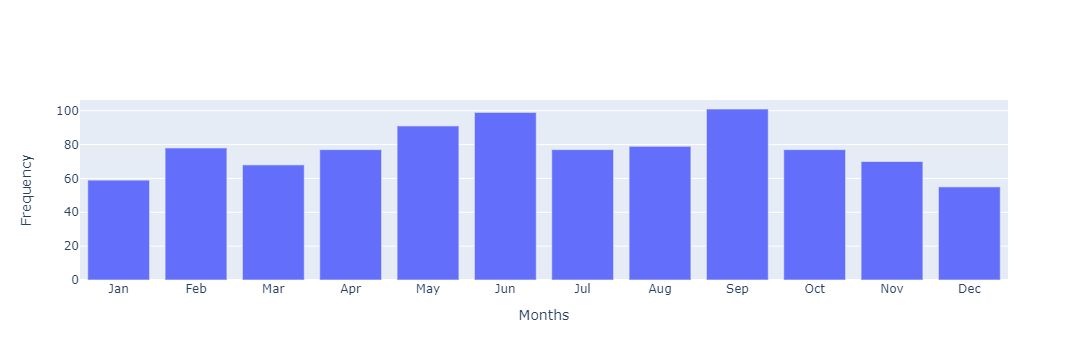

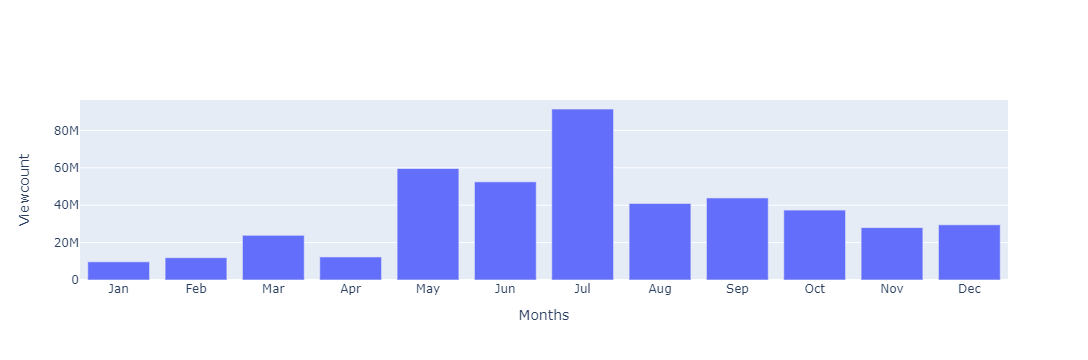

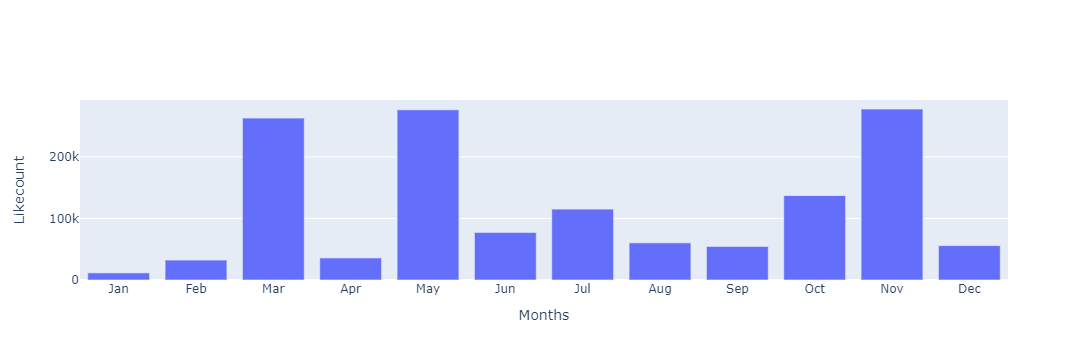

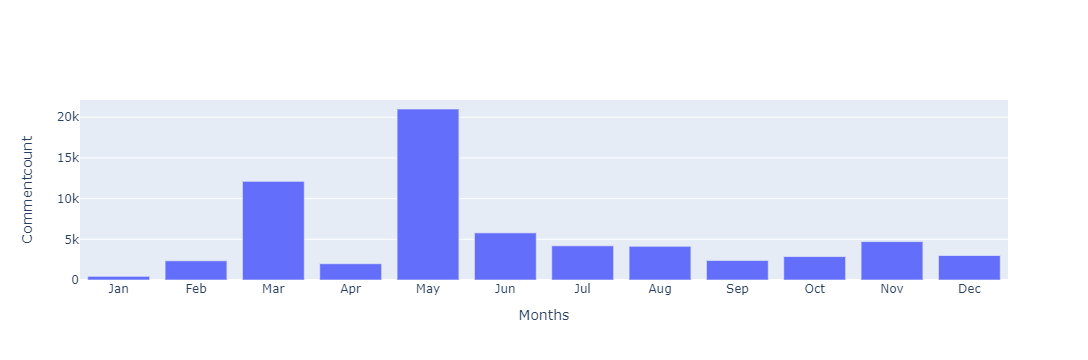

In [174]:
import plotly.graph_objs as go
from datetime import datetime

metrics = ["frequency", "viewCount", "likeCount",  "commentCount"]

for metric in metrics:
    bar_graph = []
    metric_data = [0] * len(months)

    for company, content in companies.items():
        for video, values in content["videos"].items():
            if metric == "frequency":
                metric_value = 1
            else:
                metric_value = values.get(metric, 0)  # Use .get() to handle missing data gracefully
            date = values["publishedAt"]
            month = datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ").month
            metric_data[month - 1] += metric_value

    trace = go.Bar(
        x=months,
        y=metric_data,
        name=metric.capitalize(),
    )

    bar_graph.append(trace)

    fig = go.Figure(data=bar_graph)
    fig.update_layout(
        barmode='group',
        xaxis=dict(title='Months'),
        yaxis=dict(title=metric.capitalize()),
    )

    fig.show()

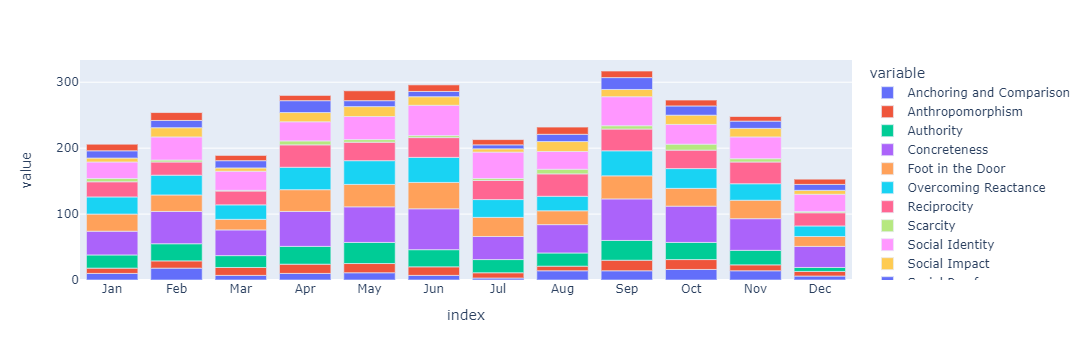

In [179]:
strategies_data = {}
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Initialize strategies_data
strategies_data = {strat: {month: 0 for month in month_order} for strat in strategies}

for company, content in companies.items():
    for video, values in content["videos"].items():
        strats = values["annots"]
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        month = date.strftime("%b")

        for strat in strats:
            strategies_data[strat][month] += 1

fig = px.bar(strategies_data)
fig.show()

#### Company

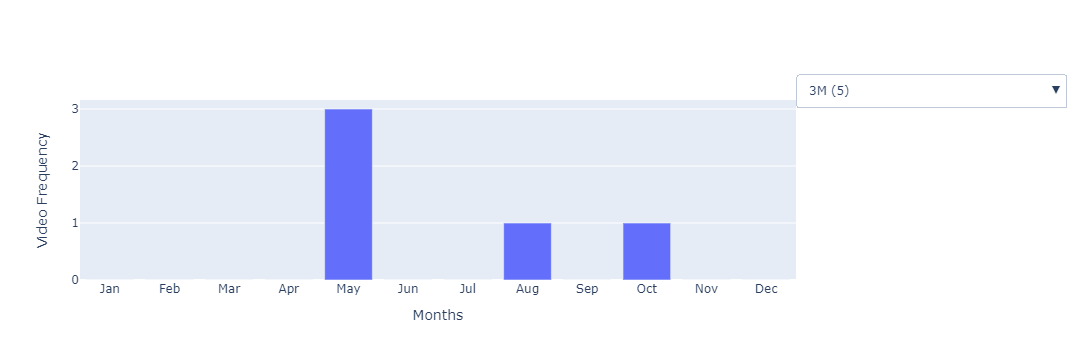

In [175]:
import plotly.graph_objs as go
from datetime import datetime

# Initialize variables for four figures
bar_graphs_likes = []
bar_graphs_views = []
bar_graphs_comments = []
bar_graphs_frequency = []

num_companies = len(companies)
plot_dicts = []

j = 0  # Initialize j here

for company, content in companies.items():
    company_likes = [0] * len(months)
    company_views = [0] * len(months)
    company_comments = [0] * len(months)
    video_frequency = [0] * len(months)

    for video, values in content["videos"].items():
        likes = values["likeCount"]
        views = values["viewCount"]
        comments = values["commentCount"]
        date = values["publishedAt"]
        month = datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ").month

        company_likes[month - 1] += likes
        company_views[month - 1] += views
        company_comments[month - 1] += comments
        video_frequency[month - 1] += 1

    if j == 0:
        visible_action = True
    else:
        visible_action = False

    trace_likes = go.Bar(
        x=months,
        y=company_likes,
        name=company,
        visible=visible_action,
    )
    bar_graphs_likes.append(trace_likes)

    trace_views = go.Bar(
        x=months,
        y=company_views,
        name=company,
        visible=visible_action,
    )
    bar_graphs_views.append(trace_views)

    trace_comments = go.Bar(
        x=months,
        y=company_comments,
        name=company,
        visible=visible_action,
    )
    bar_graphs_comments.append(trace_comments)
    
    trace_frequency = go.Bar(
        x=months,
        y=video_frequency,
        name=company,
        visible=visible_action,
    )
    bar_graphs_frequency.append(trace_frequency)

    visibility = [False] * num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}],
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j += 1

# Create figures
fig_likes = go.Figure(data=bar_graphs_likes)
fig_likes.update_layout(
    barmode='group',
    xaxis=dict(title='Months'),
    yaxis=dict(title='Likes'),
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig_views = go.Figure(data=bar_graphs_views)
fig_views.update_layout(
    barmode='group',
    xaxis=dict(title='Months'),
    yaxis=dict(title='Views'),
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig_comments = go.Figure(data=bar_graphs_comments)
fig_comments.update_layout(
    barmode='group',
    xaxis=dict(title='Months'),
    yaxis=dict(title='Comments'),
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig_frequency = go.Figure(data=bar_graphs_frequency)
fig_frequency.update_layout(
    barmode='group',
    xaxis=dict(title='Months'),
    yaxis=dict(title='Video Frequency'),
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

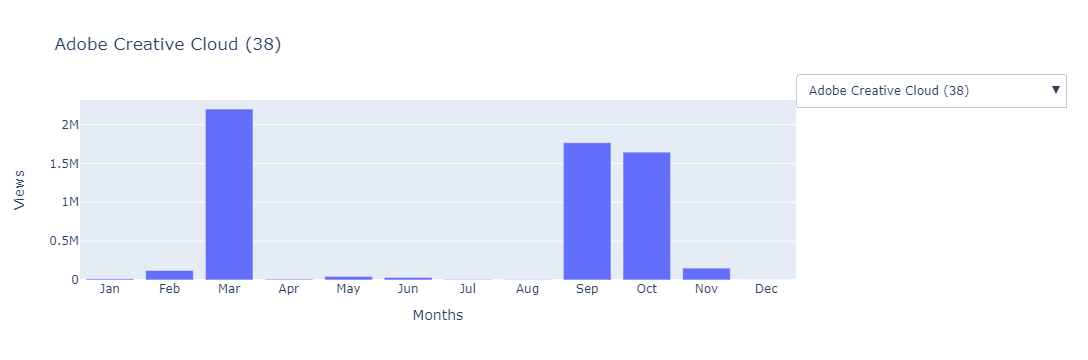

In [59]:
fig_views

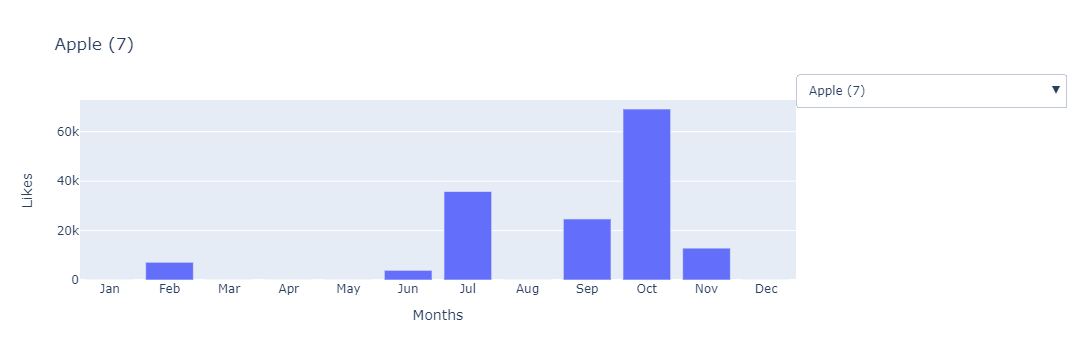

In [60]:
fig_likes

In [145]:
strategies_data = {}
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for company, content in companies.items():
    strategies_data[company] = {}
    for video, values in content["videos"].items():
        strats = values["annots"]
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        month = date.strftime("%b")

        for strat in strats:
            if strat not in strategies_data[company]:
                strategies_data[company][strat] = {month: 0 for month in month_order}
            strategies_data[company][strat][month] += 1

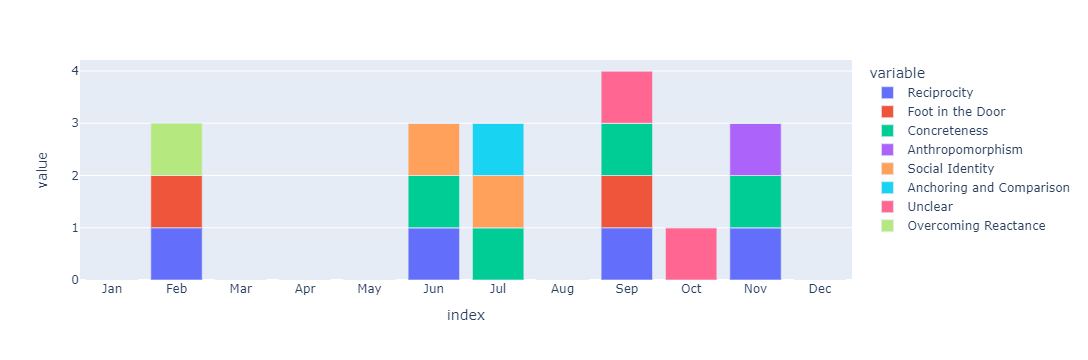

In [150]:
fig = px.bar(strategies_data['Apple'])
fig.show()

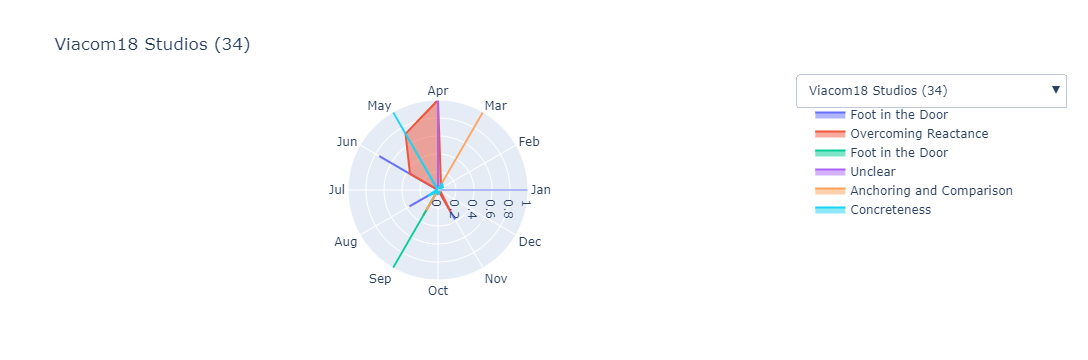

In [246]:
import plotly.graph_objects as go
from datetime import datetime
import numpy as np

polar_graphs = []
num_companies = len(companies)
plot_dicts = []
top_5_polar_plots = []
j = 0

# Initialize a dictionary to store data by strategy and month

angles = [i * (360 / len(months)) for i in range(len(months))]

for company, content in companies.items():
    data_by_strategy_and_month = {}
    company_views = {}
    company_likes = {}
    company_comments = {}
    video_frequency = {}

    for pers in persuasions:
        company_views[pers] = 0
        company_likes[pers] = 0
        video_frequency[pers] = 0

    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        likes = values["likeCount"]
        date = values["publishedAt"]
        month = datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ").month

        for strat in strats:
            if strat not in data_by_strategy_and_month:
                data_by_strategy_and_month[strat] = {month: 0 for month in range(1, 13)}
            
            data_by_strategy_and_month[strat][month] += likes

    strat_names = list(data_by_strategy_and_month.keys())

    if j == 0:
        visible_action = True
    else:
        visible_action = False

    # Create traces for each strategy
    traces = []

    for strat in strat_names:
        likes_for_strat = [data_by_strategy_and_month[strat][month] for month in range(1, 13)]

        # Normalize the values between 0 and 1
        max_likes = max(likes_for_strat)
        if max_likes != 0:
            likes_for_strat = [x / max_likes for x in likes_for_strat]

        trace = go.Scatterpolar(
            r=likes_for_strat,
            theta=angles,
            mode='lines',
            fill='toself',  # Fill area with color
            name=f"{strat}",
            visible=visible_action
        )

        traces.append(trace)

    polar_graphs.extend(traces)

    if company in top_5_company_names:
        top_5_polar_plots.extend(traces[-len(strat_names):])

    visibility = [False] * num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}],
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j += 1

fig = go.Figure(data=polar_graphs)

fig.update_layout(
    polar=dict(
        angularaxis=dict(
            tickmode='array',
            tickvals=angles,
            ticktext=months
        ),
        radialaxis=dict(
            range=[0, 1]
            # range=[0, max_likes]
        )
    )
)

fig.update_layout(
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig.show()


#### Sector

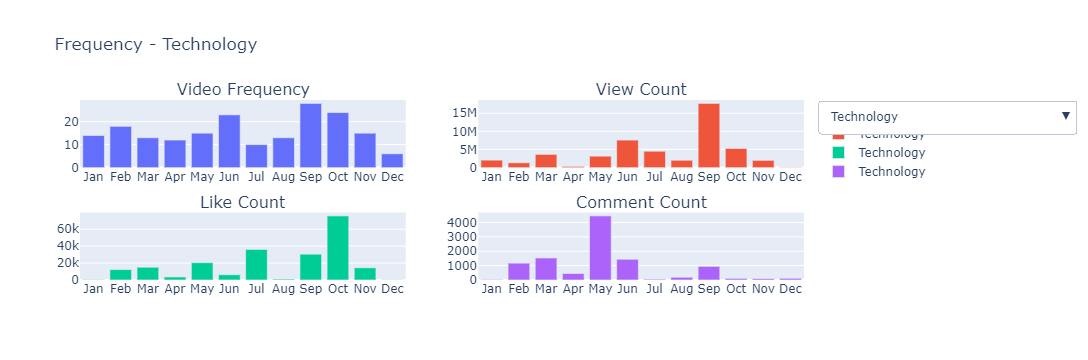

In [221]:
import plotly.graph_objs as go
from datetime import datetime
import plotly.subplots as sp
import itertools

# Initialize variables for four figures
figs = sp.make_subplots(rows=2, cols=2, subplot_titles=( "Video Frequency", "View Count", "Like Count", "Comment Count"))
num_sectors = len(sectors)

metrics = ["frequency", "viewCount", "likeCount", "commentCount"]

# Create a list of sectors
sector_list = list(sectors.keys())

# Initialize visibility list for metrics
initial_visibility = [False] * num_sectors

# Set the initial sector to be visible
initial_visibility[0] = True

# Create traces for each metric
for i, metric in enumerate(metrics):
    metric_data = []

    for sector, values in sectors.items():
        sector_metric_total = [0] * len(months)

        for video, content in values["videos"].items():
            if metric == "frequency":
                metric_value = 1
            else:
                metric_value = content[metric]
            date = datetime.strptime(content["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
            month = date.strftime("%b")

            sector_metric_total[months.index(month)] += metric_value

        metric_data.append(go.Bar(
            x=months,
            y=sector_metric_total,
            name=sector,
            visible=initial_visibility[sector_list.index(sector)],  # Set initial visibility
        ))

    row = i // 2 + 1
    col = i % 2 + 1
    for trace in metric_data:
        figs.add_trace(trace, row=row, col=col)

# Create buttons for sector selection
buttons = [
    dict(label=sector, method="update", args=[{"visible": [sector == s for s in sector_list]}, {"title": f"{metric.capitalize()} - {sector}"}])
    for sector, metric in itertools.product(sector_list, metrics)
]

# Add buttons to update the visibility based on selected sector
figs.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            buttons=buttons,
            direction="down",
            showactive=True,
            x=1.02,
            xanchor="left",
            y=1,
            yanchor="top"
        ),
    ],
    barmode='group',
    title=f"{metrics[0].capitalize()} - {sector_list[0]}",
)

figs.show()

### Metrics over Months, Years

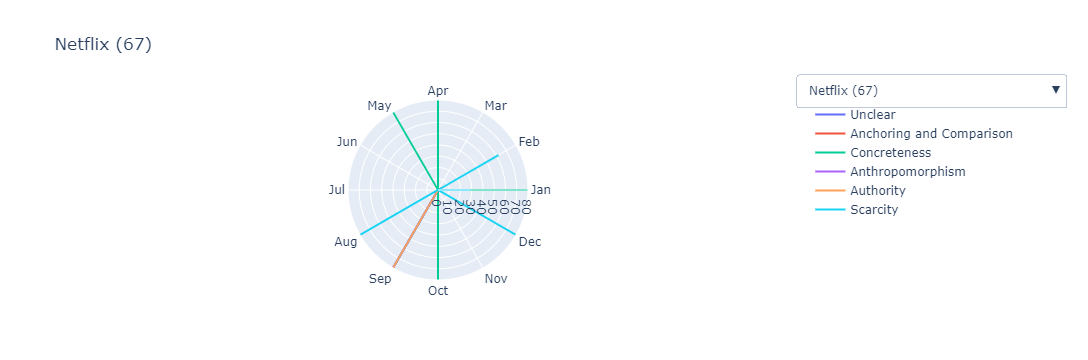

In [251]:
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import itertools

polar_graphs = []
num_companies = len(companies)
plot_dicts = []
j = 0

# Initialize a dictionary to store data by strategy, year, and month
data_by_strategy_year_and_month = {}

angles = [i * (360 / len(months)) for i in range(len(months))]

for company, content in companies.items():
    data_by_strategy_year_and_month = {}
    for video, values in content["videos"].items():
        strats = values["annots"]
        likes = values["likeCount"]
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        year = date.year
        month = date.month

        for strat in strats:
            if strat not in data_by_strategy_year_and_month:
                data_by_strategy_year_and_month[strat] = {}

            if year not in data_by_strategy_year_and_month[strat]:
                data_by_strategy_year_and_month[strat][year] = {month: 0 for month in range(1, 13)}

            data_by_strategy_year_and_month[strat][year][month] += likes

    strat_names = list(data_by_strategy_year_and_month.keys())
    max_likes = max(max(max(month_data.values()) for month_data in year_data.values()) for year_data in data_by_strategy_year_and_month.values())

    if j == 0:
        visible_action = True
    else:
        visible_action = False

    # Create traces for each strategy
    traces = []

    for strat in strat_names:
        years = list(data_by_strategy_year_and_month[strat].keys())
        years.sort()  # Sort the years

        # Create a list of months for the x-axis
        months_list = []
        for year in years:
            months_list.extend(data_by_strategy_year_and_month[strat][year].keys())
        months_list = sorted(list(set(months_list)))

        # Create a list of video frequencies for each month
        freq_for_strat = [data_by_strategy_year_and_month[strat][year][month] if month in data_by_strategy_year_and_month[strat][year] else 0
                           for year, month in itertools.product(years, months_list)]

        trace = go.Scatterpolar(
            r=freq_for_strat,
            theta=angles * len(years),  # Repeat angles for each year
            mode='lines',
            name=f"{strat}",
            visible=visible_action
        )

        traces.append(trace)

    polar_graphs.extend(traces)

    visibility = [False] * num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}],
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j += 1

fig = go.Figure(data=polar_graphs)

fig.update_layout(
    polar=dict(
        angularaxis=dict(
            tickmode='array',
            tickvals=angles,
            ticktext=months
        ),
        radialaxis=dict(
            range=[0, max_likes]  # Set the range for the radial axis to max_likes
        )
    )
)

fig.update_layout(
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig.show()


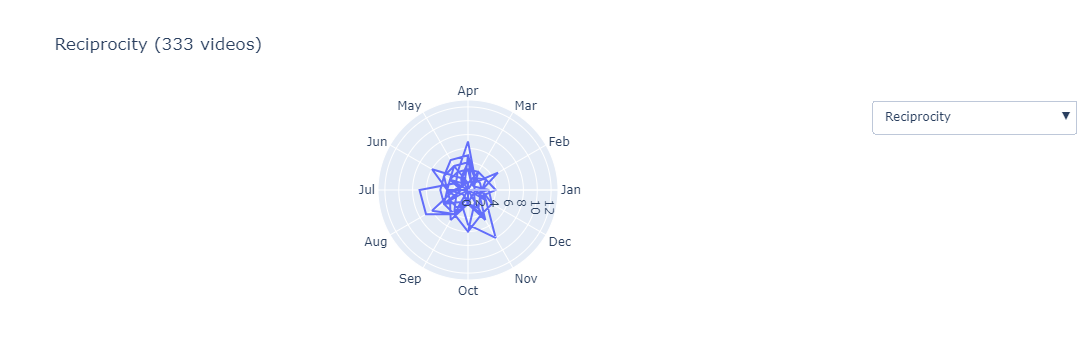

In [248]:
import plotly.graph_objects as go
from datetime import datetime
import numpy as np

strat_counts = {strat: 0 for strat in strat_names}

# Initialize a dictionary to store data by strategy, year, and month
data_by_strategy_year_and_month = {}

angles = [i * (360 / len(months)) for i in range(len(months))]

# Create a list to store traces for each strategy
traces = []

# Initialize maximum frequency
max_frequency = 0

for company, content in companies.items():
    for video, values in content["videos"].items():
        strats = values["annots"]
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        year = date.year
        month = date.month

        for strat in strats:
            if strat not in data_by_strategy_year_and_month:
                data_by_strategy_year_and_month[strat] = {}

            if year not in data_by_strategy_year_and_month[strat]:
                data_by_strategy_year_and_month[strat][year] = {month: 0 for month in range(1, 13)}

            data_by_strategy_year_and_month[strat][year][month] += 1  # Increment by 1 for video frequency

            strat_counts[strat] += 1
            
            # Update maximum frequency
            max_frequency = max(max_frequency, data_by_strategy_year_and_month[strat][year][month])

# Create buttons for strategy selection
buttons = [
    dict(label=strat, method="update", args=[{"visible": [strat == s for s in strat_names]}, {"title": f"Video Frequency - {strat} ({strat_counts[strat]} videos)"}])
    for strat in strat_names
]

# Initialize visibility list for strategies
initial_visibility = [False] * len(strat_names)

# Set the initial strategy to be visible
initial_visibility[0] = True

# Create traces for each strategy
for strat in strat_names:
    years = list(data_by_strategy_year_and_month[strat].keys())
    years.sort()  # Sort the years

    # Create a list of months for the x-axis
    months_list = []
    for year in years:
        months_list.extend(data_by_strategy_year_and_month[strat][year].keys())
    months_list = sorted(list(set(months_list)))

    # Create a list of video frequencies for each month
    freq_for_strat = [data_by_strategy_year_and_month[strat][year][month] if month in data_by_strategy_year_and_month[strat][year] else 0
                       for year, month in itertools.product(years, months_list)]

    trace = go.Scatterpolar(
        r=freq_for_strat,
        theta=angles * len(years),  # Repeat angles for each year
        mode='lines',
        name=strat,
        visible=initial_visibility[strat_names.index(strat)],  # Set initial visibility
    )

    traces.append(trace)

fig = go.Figure(data=traces)

fig.update_layout(
    polar=dict(
        angularaxis=dict(
            tickmode='array',
            tickvals=angles,
            ticktext=months
        ),
        radialaxis=dict(
            range=[0, max_frequency + 1]  # Set the range for the radial axis based on the maximum frequency
        )
    )
)

# Add buttons to update the visibility based on selected strategy
fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            buttons=buttons,
            direction="down",
            showactive=True,
            x=1.02,
            xanchor="left",
            y=1,
            yanchor="top"
        ),
    ],
    title=f"{strat_names[0]} ({strat_counts[strat_names[0]]} videos)",
)

fig.show()